In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load data
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

# Convert dates to datetime
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Merge datasets
data = transactions.merge(customers, on="CustomerID")

In [2]:
# Step 2: Feature Engineering
# Aggregate transaction data per customer
customer_features = data.groupby("CustomerID").agg(
    total_spend=("TotalValue", "sum"),
    avg_order_value=("TotalValue", "mean"),
    total_quantity=("Quantity", "sum"),
    transaction_count=("TransactionID", "count")
).reset_index()

# Merge with customer profile data
customer_data = customers.merge(customer_features, on="CustomerID")

# Select relevant features for clustering
features = customer_data[["total_spend", "avg_order_value", "total_quantity", "transaction_count"]]

# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [3]:
# Step 3: Clustering with K-Means
db_scores = []
silhouette_scores = []
cluster_range = range(2, 11)  # Test for 2 to 10 clusters
models = {}

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)

    # Store the model and labels for further analysis
    models[n_clusters] = (kmeans, cluster_labels)

    # Calculate clustering metrics
    db_index = davies_bouldin_score(scaled_features, cluster_labels)
    db_scores.append(db_index)

    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Optimal number of clusters based on DB Index
optimal_clusters = cluster_range[np.argmin(db_scores)]
print(f"Optimal Number of Clusters: {optimal_clusters}")
print(f"DB Index for Optimal Clusters: {min(db_scores)}")

Optimal Number of Clusters: 10
DB Index for Optimal Clusters: 0.9139745364618437


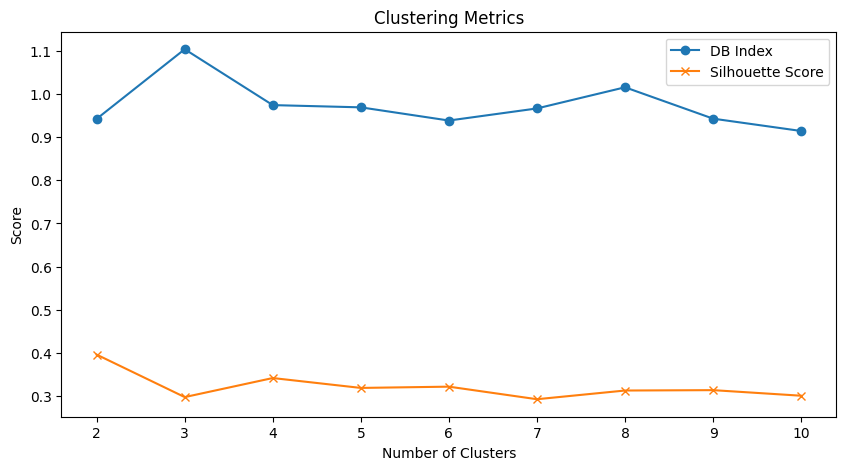

In [4]:
# Step 4: Visualize Clustering Metrics
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, db_scores, marker='o', label="DB Index")
plt.plot(cluster_range, silhouette_scores, marker='x', label="Silhouette Score")
plt.xticks(cluster_range)
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.legend()
plt.title("Clustering Metrics")
plt.show()

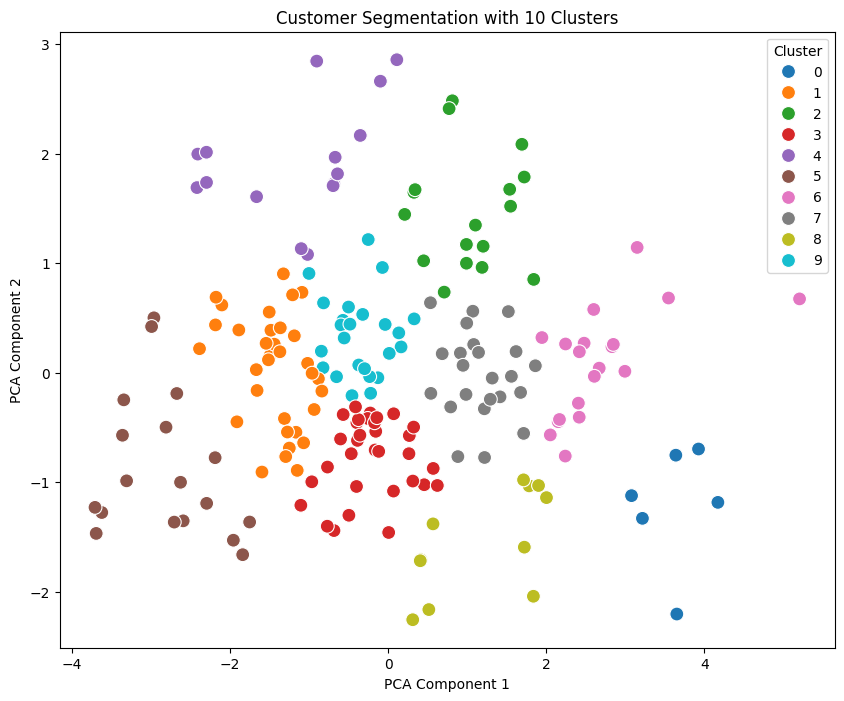

In [5]:
# Step 5: Visualize Clusters (Using PCA for Dimensionality Reduction)
# Get the optimal clustering model
optimal_model, optimal_labels = models[optimal_clusters]

# Reduce to 2D using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Plot clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=reduced_features[:, 0],
    y=reduced_features[:, 1],
    hue=optimal_labels,
    palette="tab10",
    s=100
)
plt.title(f"Customer Segmentation with {optimal_clusters} Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

In [6]:
# Step 6: Save Results
customer_data["Cluster"] = optimal_labels
customer_data.to_csv("FirstName_LastName_Clustering.csv", index=False)